# Create configuration files for Web2Cit

This notebook performs automatic creation of [Web2Cit](https://meta.wikimedia.org/wiki/Web2Cit) configuration files for the web domains evaluated in "understand-citoid-coverage.ipynb".

__Author:__

* Nidia Hernández, [nidiahernandez@conicet.gov.ar](mailto:nidiahy@gmail.com), CAICYT-CONICET


In [2]:
import os
import pandas as pd
from operator import itemgetter
import json
import gzip
from glob import glob
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()
from urllib.parse import urlparse
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/home/yoki/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Web2Cit's configuration files

Doc: https://meta.wikimedia.org/wiki/Web2Cit/Early_adopters#Domain_configuration_files

Example config file: https://meta.wikimedia.org/wiki/Web2Cit/data/com/nbcnews/www/tests.json

This is how a config file looks like:

```
[
 {
   "path": "/business/economy/july-inflation-numbers-consumer-prices-rose-85-year-year-summer-inflat-rcna42393",
   "fields": [
     {
       "fieldname": "itemType",
       "goal": [
         "newspaperArticle"
       ]
     },
     {
       "fieldname": "title",
       "goal": [
         "Consumer prices rose by 8.5% year over year in July as the summer of inflation wears on"
       ]
     },
     {
       "fieldname": "authorLast",
       "goal": [
         "Rob Wile"
       ]
     },
     {
       "fieldname": "date",
       "goal": [
         "2022-08-10"
       ]
     },
     {
       "fieldname": "publishedIn",
       "goal": [
         "NBC News"
       ]
     },
     {
       "fieldname": "language",
       "goal": [
         "en"
       ]
     }
   ]
 }
] 
```




Currently, there are 25 config files available at https://meta.wikimedia.org/wiki/Special:PrefixIndex/Web2Cit/data:

Web2Cit/data/ar/com/lavoz/www/tests.json

Web2Cit/data/ar/com/pagina12/www/tests.json

Web2Cit/data/au/gov/qld/qagoma/blog/tests.json

Web2Cit/data/br/com/uol/folha/www1/tests.json

Web2Cit/data/com/3rionoticias/tests.json

Web2Cit/data/com/aljazeera/www/tests.json

Web2Cit/data/com/cnn/edition/tests.json

Web2Cit/data/com/elespectador/www/tests.json

Web2Cit/data/com/eltiempo/www/tests.json

Web2Cit/data/com/go/abcnews/tests.json

Web2Cit/data/com/nbcnews/www/tests.json

Web2Cit/data/com/newyorker/www/tests.json

Web2Cit/data/com/revistaanfibia/tests.json

Web2Cit/data/com/thequietus/tests.json

Web2Cit/data/com/yahoo/news/tests.json

Web2Cit/data/ie/independent/www/tests.json

Web2Cit/data/ie/rte/www/tests.json

Web2Cit/data/org/adl/www/tests.json

Web2Cit/data/org/amnesty/www/tests.json

Web2Cit/data/org/cjr/www/tests.json

Web2Cit/data/uk/gov/www/tests.json

Web2Cit/data/uy/com/elobservador/www/tests.json

Web2Cit/data/uy/com/elpais/www/tests.json

Web2Cit/data/uy/com/ladiaria/tests.json

Web2Cit/data/uy/com/montevideo/www/tests.json


Our goal is to automatically produce new configuration files for the domains previously evaluated in [Understand Citoid coverage](https://github.com/hdcaicyt/Web2Cit-research/blob/main/understand-citoid-coverage.ipynb) notebook.

Some information about the fieldnames of the configuration files 

* itemType: mandatory. Single value
* title: mandatory. Single value, empty string not allowed.
* authorLast: may have multiple values. Can be last name(s) or full name(s).
* authorFirst: may have multiple values.
* date: single value. YYYY-MM-DD format
* publishedBy: single value.
* publishedIn: single value.
* language: single value.

More information at: https://meta.wikimedia.org/wiki/Web2Cit/Early_adopters#Translation_fields

We will extract the data for these fields from the following columns in our evaluation dataframe:

* itemType: source_type_manual and source_type_citoid
* title: title_manual
* authorLast: author_last_manual
* authorFirst: author_first_manual
* date: pub_date_manual
* publishedBy: undefined (can't be recovered, pub_source_manual is a mix of publishedBy and publishedIn)
* publishedIn: undefined (can't be recovered)
* language: undefined (can't be recovered, we do not have the publishing langauage in our df)

In [3]:
## Read evaluation results df
citoid_eval = pd.read_csv("eval/eval_all_citations.csv.gz")
cols = ['author_first_citoid', 'author_last_citoid', 'source_type_manual', 'title_manual',
       'author_last_manual', 'author_first_manual', 'pub_date_manual'] # 'pub_source' will not be used, it can't be mapped

# read data as lists
for col in cols:
    citoid_eval[col] = citoid_eval[col].fillna('None').map(eval)

In [4]:
print(f"There are {len(citoid_eval)} citations in our evaluation corpus")

There are 91338 citations in our evaluation corpus


In [5]:
citoid_eval.columns

Index(['url', 'url_citoid', 'source_type_citoid', 'title_citoid',
       'author_first_citoid', 'author_last_citoid', 'pub_date_citoid',
       'pub_source_citoid', 'citation_template', 'source_type_manual',
       'title_manual', 'author_last_manual', 'author_first_manual',
       'pub_date_manual', 'pub_source_manual', 'article_url', 'page_id',
       'revid', 'wiki_lang', 'comp_title', 'comp_source_type',
       'comp_pub_source', 'comp_pub_date', 'comp_author_first',
       'comp_author_last'],
      dtype='object')

In [6]:
## caculate scores
comp_fields = ['comp_author_first', 'comp_author_last', 'comp_title',
          'comp_source_type', 'comp_pub_source', 'comp_pub_date']

citoid_eval["citoid_success"] = (citoid_eval[comp_fields] >= 0.75).sum(axis=1)

In [7]:
## find domains
citoid_eval['domain'] = citoid_eval['url'].map(lambda x : urlparse(x).netloc)

In [8]:
print(f"There are {len(citoid_eval.domain.drop_duplicates())} domains in our evaluation corpus")

There are 15501 domains in our evaluation corpus


In [9]:
## calculate domain popularity (count domain freq)
citoid_eval["domain_counts"] = citoid_eval.groupby('domain')["domain"].transform("count")

In [10]:
## calculate domain score
citoid_eval["domain_score"] = citoid_eval.groupby("domain")["citoid_success"].transform("mean")

## Select citations for config files

To be elegible for generating a configuration file, a citation must:

- have information for at least 3 of the following 4 fields: title, author_first, author_last, and pub_date
- have a success score lower than 50% (we prioritize domains for which Citoid's performance can be improved)
- belong to a domain cited at least X times in our corpus of evaluated URLs (we are interested in high frequency domains)


In [11]:
citoid_eval.head()

,url,url_citoid,source_type_citoid,title_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid,citation_template,source_type_manual,...,comp_title,comp_source_type,comp_pub_source,comp_pub_date,comp_author_first,comp_author_last,citoid_success,domain,domain_counts,domain_score
0,https://www.theage.com.au/entertainment/movies...,https://www.theage.com.au/entertainment/movies...,webpage,bollywood on bourke street,None,None,2005-05-13,the age,cite news,"[magazineArticle, newspaperArticle]",...,1.00,0,0.00,1.0,1.0,0.00,3,www.theage.com.au,21,4.428571
1,https://books.google.com/books?id=QSwEAAAAMBAJ...,https://books.google.com/books?id=QSwEAAAAMBAJ...,book,vibe,[vibe media],[group],1997-01,vibe media group,cite magazine,[],...,0.05,0,1.00,0.0,0.2,0.12,1,books.google.com,8486,3.613952
2,https://www.ecaho.org/about-ecaho/about-us,https://www.ecaho.org/about-ecaho/about-us,webpage,about ecaho - ecaho,None,None,NaN,www.ecaho.org,Lien web,"[blogPost, email, forumPost, podcast, videoRec...",...,0.58,1,1.00,1.0,1.0,1.00,5,www.ecaho.org,1,5.000000
3,https://www.gq.com/story/pacific-rim-uprising-...,https://www.gq.com/story/pacific-rim-uprising-...,webpage,the 'pacific rim uprising' director tells us a...,[conde],[nast],2018-03-23,gq,cite web,"[blogPost, email, forumPost, webpage]",...,0.22,1,1.00,1.0,0.2,0.17,3,www.gq.com,33,2.515152
4,http://bgtfans.com/2013/fifth-falcons-fury-tow...,http://bgtfans.com/2013/fifth-falcons-fury-tow...,webpage,NaN,None,None,NaN,bgtfans.com,cite web,"[blogPost, email, forumPost, webpage]",...,0.00,1,0.55,0.0,1.0,1.00,3,bgtfans.com,11,3.000000


We eliminate these citations because we do not want to generate config files having wikicode in the goal:

In [12]:
data_with_wikicode = [34454, 37306, 52070, 62452, 67658] 
citoid_eval = citoid_eval.drop(data_with_wikicode) 

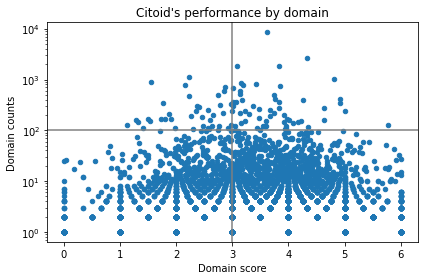

In [301]:
## plot data
## low score high popularity

plot_data_full = citoid_eval[["domain", "domain_score", "domain_counts"]].copy().drop_duplicates()
plot_data = plot_data_full
#plot_data = plot_data.drop(1) # exclude books.google.com 
#plot_data = plot_data.drop(6) # exclude www.nytimes.com

ax = plot_data.plot.scatter(x="domain_score", y="domain_counts")
ax.axhline(100, color='grey', linestyle='-')
ax.axvline(3, color='grey', linestyle='-')

ax.set_title("Citoid's performance by domain")
ax.set_ylabel("Domain counts")
ax.set_xlabel("Domain score")

ax.set_yscale("log")

plt.savefig("plots/low_score_high_popularity_domains.png")
plt.tight_layout()
plt.show()

Observaciones sobre la distribución rara por debajo de 10 counts (eje y $10^{1}$): en el caso de $10^{0} = 1$ se ve que abajo de todo el grafico aparecen valores discretos porque para dominios de una sola ocurrencia no hay promedio!

From this plot, we decided to select domains being cited at least 100 times in our corpus.

In [219]:
## filter by required metadata
required_fields = ['author_first_manual', 'author_last_manual', 'title_manual', 'pub_date_manual']
mask = (citoid_eval[required_fields].applymap(len) > 0).sum(axis=1) > 2
citations4conf = citoid_eval[mask]

In [220]:
score_threshold = 3 # max score is 6
citations4conf = citations4conf[citations4conf["domain_score"] < score_threshold]

In [221]:
## filter by domain frequency
popularity_threshold = 100
citations4conf = citations4conf[citations4conf["domain_counts"] > popularity_threshold]

In [222]:
print(f"We have {len(citations4conf)} citations left")

We have 7056 citations left


In [223]:
## Sort by domain score, from lower to higher
citations4conf = citations4conf.sort_values(by=["domain_score"], ascending=True)

In [224]:
print(f"We have {len(citations4conf['domain'].drop_duplicates())} domains left")

We have 39 domains left


These are the domains having the lowest scores and higher citation frequency:

In [225]:
citations4conf[["domain","domain_score","domain_counts"]].drop_duplicates()

,domain,domain_score,domain_counts
8396,nl.newsbank.com,1.128000,125
66829,darwin-online.org.uk,1.288462,156
27381,docs.newsbank.com,1.328671,143
69908,tvbythenumbers.zap2it.com,1.405405,111
60739,www.ibiblio.org,1.493976,166
8093,people.com,1.542484,153
20504,news.google.com,1.543237,902
35194,usatoday30.usatoday.com,1.723529,170
73389,ew.com,1.757143,350
1631,www.robertchristgau.com,1.793939,165


For each domain, we keep the two citations having the lowest score.

In [235]:
## URL selection
citations4conf = citations4conf.sort_values(by="citoid_success").groupby("domain").head(2)

## Recover metadata without preprocessing

The data in our dataframe has been previously normalized (see Data normalization section in our [evaluation notebook](https://github.com/hdcaicyt/Web2Cit-research/blob/main/understand-citoid-coverage.ipynb)). For the configuration files, we are interested in the original metadata.

### Manual metadata without preprocessing

In [237]:
## This file contains the manual citations metadata before preprocessing
manual_before_preproc = pd.read_csv("data/citations_metadata_only_year.csv.gz")

cols = ['title','author_last', 'author_first', 'pub_date'] # 'pub_source' will not be used

manual_before_preproc = manual_before_preproc.drop_duplicates(subset=["url"], keep="first")

for col in cols:
    manual_before_preproc[col] = manual_before_preproc[col].fillna('None').map(eval)

In [238]:
manual_before_preproc.columns

Index(['article_title', 'article_url', 'page_id', 'revid', 'wiki_lang', 'url',
       'source_type', 'source_type_map', 'title', 'title_clean', 'author_last',
       'author_last_clean', 'author_first', 'author_first_clean', 'pub_date',
       'pub_date_clean', 'pub_date_control', 'pub_date_only_year',
       'pub_source', 'pub_source_clean'],
      dtype='object')

In [239]:
manual_before_preproc = manual_before_preproc.set_index("url").reindex(columns=cols)
manual_before_preproc.shape

(382983, 4)

Replace data in dataframe of top cited domains with low score with data before preprocessing for 'title','author_last' and 'author_first'. 'pub_date' is not necessary because we will keep data transformed to YYYY-MM-DD and 'pub_source' is not necessary because it will not be mapped to the config file, as explained above.

In [240]:
cols = ['title','author_last', 'author_first'] ## do not overwrite pub_date!

for col in cols:
    citations4conf[f"{col}_manual"] = manual_before_preproc.loc[ citations4conf["url"], col ].values

In [241]:
citations4conf[['source_type_citoid','source_type_manual','title_manual','author_first_manual','author_last_manual', 'pub_date_manual']].sample(6)
#citations4conf[['source_type_citoid','source_type_manual','title_manual','author_first_manual','author_last_manual', 'pub_date_manual']].iloc[80:90]

,source_type_citoid,source_type_manual,title_manual,author_first_manual,author_last_manual,pub_date_manual
87126,webpage,"[magazineArticle, newspaperArticle]",[Jennifer Lawrence: President Trump would be '...,[Nicole],[Sperling],[2015-10-01]
9491,webpage,"[magazineArticle, newspaperArticle]",[Suits pile up on north–south Tollway],[Robert],[Enstad],[1990-04-29]
47446,webpage,"[blogPost, email, forumPost, webpage]",[Produto Interno Bruto dos Municípios - 2018],[],[IBGE Cidades],[2018]
84097,webpage,"[artwork, audioRecording, bill, bookSection, c...",[Album Review: Vangelis: ''Blade Runner Trilog...,[Mike],[Orme],[2008-02-07]
2027,webpage,[],[New York Dolls: 'Too Much Too Soon'],[Robert],[Christgau],[2005-10-25]
86916,webpage,"[blogPost, email, forumPost, webpage]",[Destiny's Former Children Settle Suit],[Rob],[Mancini],[2000-03-24]


In [242]:
citations4conf.to_csv("data/citations_for_config_files.csv", index=False)

In [ ]:
# config_data = citations4conf[['url', 'domain', 'source_type_citoid', 'source_type_manual','title_manual',
#               'author_last_manual', 'author_first_manual', 'pub_date_manual',
#               'comp_author_first', 'comp_author_last', 'comp_title', 'comp_source_type',
#                                    'comp_pub_date', 'citoid_success']]

In [ ]:
## Test rows: complete data, missing data, author_last only and several authors
#test_rows = [21721, 15267, 53687, 28688] + [59273, 36292, 86053]
#citations4conf.loc[test_rows]

In [ ]:
#citations4conf.loc[3915].title_manual

## Build config files

* If we do not have metadata for a field in our selected citations ("[]" or None), we exclude the field from the configuration file
* We do not include itemType metadata because in the results of the research we saw it is not reliable information even if there is a match between Citoid data and manual data
* For title and date fields, only one value is admitted in the configuration file. If we have more than one value in our selection, include the exact match
* For authorLast and authorFirst, if we have metada, we map it directly

In [292]:
## map evaluation fieldnames to w2c fieldnames
eval_w2c = {
    'source_type_manual':'itemType',
    'title_manual': 'title',
    'author_first_manual': 'authorFirst',
    'author_last_manual': 'authorLast', 
    'pub_date_manual': 'date',
}

def add_field(d, fieldname, row):
    el = {"fieldname": eval_w2c[fieldname]}
    el["goal"] = row[fieldname]
    d["fields"].append(el)
    return d


def row_to_json(row):
    '''
    Transforms row from evaluation df to w2c configuration file
    input: row
    output: json
    '''
    d = {}
    path = urlparse(row["url"]).path
    query = urlparse(row["url"]).query
    d["path"] = f"{path}?{query}" if query else path
    d["@comment"] = "Automatically created. See https://github.com/hdcaicyt/Web2Cit-research/blob/main/create-config-files.ipynb"
    d["fields"] = []
            
    for fieldname in ['source_type_manual','title_manual','author_first_manual','author_last_manual', 'pub_date_manual']:
        if row[fieldname]:
            if fieldname == 'author_first_manual' or fieldname == 'author_last_manual':
                add_field(d, fieldname, row)
            else:
                ## cases of more than one value in source_type, title or pub_date
                if len(row[fieldname]) > 1:
                    name = fieldname.replace("_manual", "")
                    ## if the comparison score is 1, there was a match with Citoid data
                    if row[f"comp_{name}"] == 1:
                            el = {"fieldname": eval_w2c[fieldname]}
                            el["goal"] = row[f"{name}_citoid"]
                            d["fields"].append(el)
                else:
                    add_field(d, fieldname, row)
        ## cases of missing data:
        ## do not add fieldname to config file
    return d

In [294]:
os.makedirs("data/config_files", exist_ok=True)

for ix, row in citations4conf.iterrows():
    el = row_to_json(row)
    domain = urlparse(row["url"]).netloc
    revdomain = ".".join(domain.split(".")[::-1])
    fp = f"data/config_files/{revdomain}.tests.json"
    
    if not os.path.isfile(fp):
        with open(fp, "w") as fo:
            json.dump([el], fo, indent=4)
    else:
        ## Add 2nd config
        with open(fp) as fi:
            config = json.load(fi)
            config.append(el)
        
        with open(fp, "w") as fo:
            json.dump(config, fo, indent=4)
            

In [293]:
#! rm data/config_files/*

In [260]:
! ls data/config_files | wc -l

39


In [270]:
ls data/config_files

ar.com.google.books.tests.json          com.people.tests.json
br.com.uol.folha.www1.tests.json        com.pitchfork.tests.json
br.gov.ibge.cidades.tests.json          com.robertchristgau.www.tests.json
com.allmusic.www.tests.json             com.usatoday.usatoday30.tests.json
com.amazon.www.tests.json               com.vanityfair.www.tests.json
com.chicagotribune.www.tests.json       com.variety.tests.json
com.cnn.edition.tests.json              com.zap2it.tvbythenumbers.tests.json
com.cnn.www.tests.json                  edu.pomona.www.tests.json
com.cyclingnews.autobus.tests.json      fr.google.books.tests.json
com.deadline.tests.json                 gov.nasa.history.tests.json
com.ew.tests.json                       gov.nps.www.tests.json
com.gamekult.www.tests.json             net.eurogamer.www.tests.json
com.globo.globoesporte.tests.json       org.ibiblio.www.tests.json
com.go.abcnews.tests.json               org.npr.www.tests.json
com.google.news.tests.json              uk.co.bbc.

In [295]:
## Check metadata extraction
fp= "data/config_files/com.allmusic.www.tests.json"
with open(fp) as fi:
    config = json.load(fi)
    
pprint(config)

[{'@comment': 'Automatically created. See '
              'https://github.com/hdcaicyt/Web2Cit-research/blob/main/create-config-files.ipynb',
  'fields': [{'fieldname': 'title',
              'goal': ['Megadeth: That One Night: Live in Buenos Aires']},
             {'fieldname': 'authorFirst', 'goal': ['Greg']},
             {'fieldname': 'authorLast', 'goal': ['Prato']},
             {'fieldname': 'date', 'goal': ['2007-03-27']}],
  'path': '/album/that-one-night-live-in-buenos-aires-mw0000487698'},
 {'@comment': 'Automatically created. See '
              'https://github.com/hdcaicyt/Web2Cit-research/blob/main/create-config-files.ipynb',
  'fields': [{'fieldname': 'title',
              'goal': ['AllMusic Review by Stephen Thomas Erlewine']},
             {'fieldname': 'authorFirst', 'goal': ['Stephen Thomas']},
             {'fieldname': 'authorLast', 'goal': ['Erlewine']},
             {'fieldname': 'date', 'goal': ['2001-03-06']}],
  'path': '/album/3-of-hearts-mw0000004177'}]


In [300]:
domain = "www.allmusic.com"
citations4conf[citations4conf.domain == domain][["url","source_type_citoid", "source_type_manual","title_manual", "author_first_manual", "author_last_manual", "pub_date_manual"]]

,url,source_type_citoid,source_type_manual,title_manual,author_first_manual,author_last_manual,pub_date_manual
40840,https://www.allmusic.com/album/that-one-night-...,audioRecording,"[blogPost, email, forumPost, webpage]",[Megadeth: That One Night: Live in Buenos Aires],[Greg],[Prato],[2007-03-27]
88596,https://www.allmusic.com/album/3-of-hearts-mw0...,audioRecording,"[blogPost, email, forumPost, webpage]",[AllMusic Review by Stephen Thomas Erlewine],[Stephen Thomas],[Erlewine],[2001-03-06]


In [ ]:
## Check results in https://web2cit.toolforge.org

In [298]:
domain = "ar.com.google.books"
domain = "br.com.folha.www1"
domain = "com.allmusic.www"
domain = "com.google.news"
domain = ".".join(domain.split(".")[::-1])
citations4conf[citations4conf.domain == domain]

,url,url_citoid,source_type_citoid,title_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid,citation_template,source_type_manual,...,comp_title,comp_source_type,comp_pub_source,comp_pub_date,comp_author_first,comp_author_last,citoid_success,domain,domain_counts,domain_score
43874,https://news.google.com/newspapers?nid=950&dat...,https://news.google.com/newspapers?nid=950&dat...,webpage,the evening independent - google news archive ...,None,None,NaN,news.google.com,cite news,"[magazineArticle, newspaperArticle]",...,0.19,0,0.13,0.0,0.0,0.0,0,news.google.com,902,1.543237
90182,https://news.google.com/newspapers?id=uWdKAAAA...,https://news.google.com/newspapers?id=uWdKAAAA...,webpage,the telegraph - google news archive search,None,None,NaN,news.google.com,cite news,"[magazineArticle, newspaperArticle]",...,0.14,0,0.00,0.0,0.0,0.0,0,news.google.com,902,1.543237


In [299]:
citations4conf[citations4conf.domain == domain].loc[90182].url

'https://news.google.com/newspapers?id=uWdKAAAAIBAJ&sjid=25MMAAAAIBAJ&pg=6666,7567657'